# General 2-planet system

Derive the precession mode frequencies and amplitudes for a generic, closely-packed, 2-planet system. By generic, we mean that each planet has a generic set of initial conditions for (mass, semimajor axis, inclination).

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 7)
import time

import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

# Method 1: Simulation

We initialize the inclinations so that their relative inclinations are modeled with a Rayleigh distribution with scale 1.8. Later, we will reorient the system so that its total angular momentum axis points along the z-axis (thus changing the inclinations to their "true" values.)

In [2]:
# initialize inclinations (this is *not* in the L_tot frame)
rng = default_rng()
inc_scale = 1.8 * np.pi / 180 # inclination scale in radians

# b_inc_0_rad = rng.rayleigh(scale=inc_scale)
# c_inc_0_rad = rng.rayleigh(scale=inc_scale)
b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338
print(f'b_inc_0_rad = %.9f' % b_inc_0_rad)
print(f'c_inc_0_rad = %.9f' % c_inc_0_rad)

b_inc_0_rad = 0.039505988
c_inc_0_rad = 0.069253338


In [3]:
## Initialize simulation
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')

M_e = 3.00273e-6 # Earth mass in Msun

star_mass = 1.0
P_ratio = 1.51

# Each planet has 4 provided params: mass (m) in Earth masses, semimajor axis (a), 
# inclination (inc), and Omega. The three omitted orbital params (e, f, omega) 
# are left at their default values of 0.
b_params = {
    "m": 4.19 * M_e, 
    "a": 0.0719, 
    "inc": b_inc_0_rad,
    "Omega": 0
}

c_params = {
    "m": 4.16 * M_e, 
    "a": b_params['a'] * P_ratio**(2/3), # a \propto P^(2/3)
    "inc": c_inc_0_rad,
    "Omega": np.pi
}

sim.add(m=star_mass)
sim.add(m=b_params['m'], a=b_params['a'], inc=b_params['inc'], Omega=b_params['Omega'])
sim.add(m=c_params['m'], a=c_params['a'], inc=c_params['inc'], Omega=c_params['Omega'])

# Rotate the axes so that z points along the total angular momentum.
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())
sim.rotate(rot)

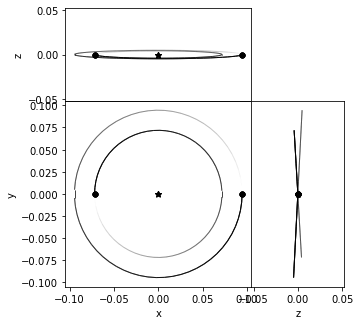

In [4]:
op_set = rebound.OrbitPlotSet(sim)

In [5]:
Lx, Ly, Lz = sim.angular_momentum()
Lx, Ly, Lz

(-1.88079096131566e-37, 4.235164736271502e-22, 4.527347721703696e-05)

In [10]:
## check the particles' inclinations after the frame shift
print(f"Planet B's inc (L_tot frame) = %.9f" % sim.particles[1].inc)
print(f"Planet C's inc (L_tot frame) = %.9f" % sim.particles[2].inc)

Planet B's inc (L_tot frame) = 0.057918189
Planet C's inc (L_tot frame) = 0.050841137


## Run sim

Per Appendix 1 in Su & Lai (2022), we track complex inclination $\mathcal{I}_j \equiv I_j \text{exp}(i \Omega_j)$.

In [32]:
tstep = 1
tmax = 4e3 # end time of integration (yr)
num_steps = int(tmax / tstep)
N = num_steps

b_incs_rad = np.asarray([0.] * num_steps) # inclination (radians) of Planet B over the sim
c_incs_rad = np.asarray([0.] * num_steps) # inc (radians) of Planet C over the sim

b_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet B over the sim
c_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Planet C over the sim

b_as = np.asarray([0.] * num_steps) # semimajor axis of Planet B over the simulation
c_as = np.asarray([0.] * num_steps) # a of Planet C over the simulation

times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    # update inclination arrays
    inc_b = sim.particles[1].inc
    inc_c = sim.particles[2].inc
    b_incs_rad[i] = inc_b
    c_incs_rad[i] = inc_c
    
    # update complex inclination arrays
    Omega_i_b = sim.particles[1].Omega
    Omega_i_c = sim.particles[2].Omega
    b_complex_incs_rad[i] = inc_b * np.exp(1j * Omega_i_b)
    c_complex_incs_rad[i] = inc_c * np.exp(1j * Omega_i_c)
    
    # update semimajor axis arrays
    b_as[i] = sim.particles[1].a
    c_as[i] = sim.particles[2].a
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

KeyboardInterrupt: 

In [ ]:
# check that semimajor axes aren't wandering
fig = plt.figure(figsize=(10,6))

plt.plot(times, b_as, label='Planet B')
plt.plot(times, c_as, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('a (AU)')
plt.ylim(0, .12)

plt.title('Semimajor axis (a) vs. time')
plt.legend(loc='lower right')
plt.show()

In [14]:
# convert inclinations from radians to degrees
b_incs_deg = b_incs_rad * (180 / np.pi)
c_incs_deg = c_incs_rad * (180 / np.pi)
b_complex_incs_deg = b_complex_incs_rad * (180 / np.pi)
c_complex_incs_deg = c_complex_incs_rad * (180 / np.pi)

# save data
file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, b_complex_incs_deg, c_complex_incs_deg), f)

## Load in sim data

In [6]:
# load in data, if necessary
load_data = False
if load_data:
    tstep = int(1)
    tmax = 4e3
    num_steps = int(tmax)
    N = int(num_steps)

    file_path = f'bc_complex_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, b_complex_incs_deg, c_complex_incs_deg = pickle.load(f)

In [ ]:
b_incs_deg = np.abs(b_complex_incs_deg)
c_incs_deg = np.abs(c_complex_incs_deg)

#fig = plt.figure(figsize=(10,6))

plt.plot(times, b_incs_deg, linewidth=0.3, label='Planet B')
plt.plot(times, c_incs_deg, linewidth=0.3, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination (deg)')
plt.title('Physical inclination')

plt.legend(loc='lower right')
plt.show()

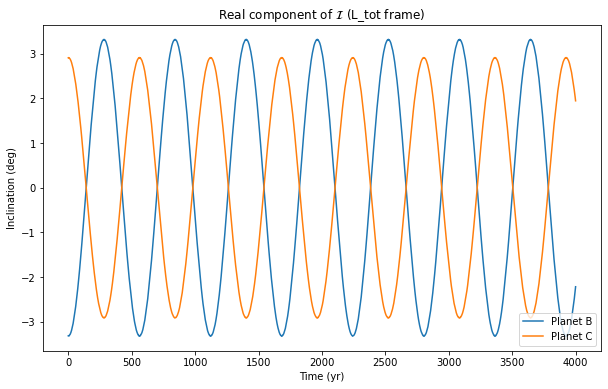

In [24]:
fig = plt.figure(figsize=(10,6))

plt.plot(times, b_complex_incs_deg.real, label='Planet B')
plt.plot(times, c_complex_incs_deg.real, label='Planet C')

plt.xlabel('Time (yr)')
plt.ylabel('Inclination (deg)')
plt.title('Real component of $\mathcal{I}$ (L_tot frame)')

plt.legend(loc='lower right')
plt.show()

### Frame shift

**NOTE:** This calculation is irrelevant for this version of `two_planet.ipynb` since we already did the frame shift. I've left it here for the sake of having an intuitive understanding of what the frame shift does.

The goal is to find the frame shift $i_\text{ctr}$; i.e., the inclination of $\vec{L}_\text{tot}$ in our frame.

$\vec{L}_\text{tot}$ at $t=0$ is conserved. For two planets, this looks like:
$$L_\text{tot} = m_1 v_1 r_1 \hat{L}_1 + m_2 v_2 r_2 \hat{L}_2 = m_1 \frac{2\pi a_1}{P_1} a_1 \hat{L}_1 + m_2 \frac{2\pi a_2}{P_2} a_2 \hat{L}_2 = m_1 \sqrt{GM a_1} \hat{L}_1 + m_2 \sqrt{GM a_2} \hat{L}_2$$
where we use Kepler's third law to make the substitution $P = \frac{2\pi}{\sqrt{GM}} a^{3/2}$.

Assume that $i_1 > 0$ and its L vector points in the +x direction, while $i_2 > 0$ and its L vector points in the negative x direction.  
(**TODO:** fill in more of the math) Taking the x-component of our last equation yields:
$$m_1\sqrt{a_1} \sin{i_1} - m_2\sqrt{a_2} \sin{i_2} = \frac{L_\text{tot}}{\sqrt{GM}} \sin{i_\text{ctr}} = \sqrt{m_1^2 a_1 + m_2^2 a_2 + 2 m_1 m_2 \sqrt{a_1 a_2} \cos(i_1 + i_2)} \sin{i_\text{ctr}}$$
Plugging in values yields something consistent with what we see in the simulation data! (see the below cell)

In [26]:
# # plug values into frame shift formula
# m1, m2 = b_params['m'], c_params['m']
# a1, a2 = b_params['a'], c_params['a']
# i1, i2 = b_params['inc'], c_params['inc']

# LHS = m1 * np.sqrt(a1) * np.sin(i1) - m2 * np.sqrt(a2) * np.sin(i2)
# RHS_coeff_sq = m1**2 * a1 + m2**2 * a2 + 2*m1*m2*np.sqrt(a1*a2)*np.cos(i1 + i2)
# RHS_coeff = np.sqrt(RHS_coeff_sq)

# sin_i_ctr = LHS / RHS_coeff
# i_ctr = np.arcsin(sin_i_ctr)
# i_ctr_deg = i_ctr * 180 / np.pi

# print(f'i_ctr = %.6f rad = %.6f deg' % (i_ctr, i_ctr_deg))
# #print(f'i_ctr = %.4f deg' % sin_i_ctr)

## plot complex incs in complex plane

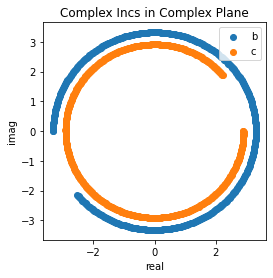

In [30]:
temp_range = slice(0, 500)

plt.figure(figsize=(4,4))

plt.scatter(b_complex_incs_deg.real[temp_range], \
            b_complex_incs_deg.imag[temp_range], label='b')
plt.scatter(c_complex_incs_deg.real[temp_range], \
            c_complex_incs_deg.imag[temp_range], label='c')

plt.xlabel('real')
plt.ylabel('imag')
plt.title('Complex Incs in Complex Plane')
plt.legend(loc='upper right')
plt.show()

## Apply FFT to sim data

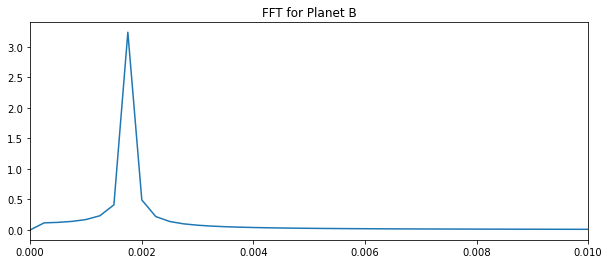

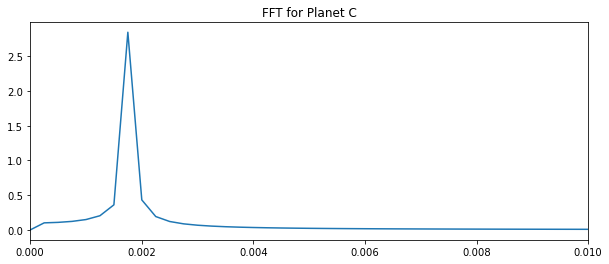

Planet B freq: 1.750e-03 years^-1
Planet B period: 571.43 years
Planet B amplitude: 3.240 deg

Planet C freq: 1.750e-03 years^-1
Planet C period: 571.43 years
Planet C amplitude: 2.844 deg


In [50]:
def quad_fn(coeffs, x):
    '''
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_freq_amp(incs, planet_name, quad_interp=False):
    '''
    Given a time series (incs) representing either component of complex inclination, 
    return the frequency and amplitude of the time series. Includes an option
    to apply quadratic interpolation around the FFT's peak.
    
    NOTE: This implementation is for 2 planets.
    
    ARGUMENTS
    ---------
    incs: time series of either the real or imag component of a complex inclination series
    planet_name: string representing planet name (used in plots)
    quad_interp: if True, uses quadratic interpolation to improve the result
    of low-resolution FFTs; default is False
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.figure(figsize=(10,4))
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 0.01)
    plt.title('FFT for ' + planet_name)
    plt.show()
    
    # run quadratic interpolation on the FFT
    if quad_interp:
        x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
        y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
        y_vals_scaled = 2 / num_steps * np.abs(y_vals)

        # get coefficients of the interpolated quadratic function
        coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
        a, b, c = coeffs

        # get mode freq and amplitude
        mode_f = - b / (2*a) # peak of the quadratic function
        mode_amp = quad_fn(coeffs, mode_f)

        # return period (years) and amplitude
        return mode_f, mode_amp

    # (result from no quadratic interpolation)
    # return freq (years) and amplitude (degrees)
    return xf[np.argmax(yf)], yf_scaled[np.argmax(yf)]

b_series = b_complex_incs_deg.real
c_series = c_complex_incs_deg.real

use_interp = False
b_freq, b_amp = FFT_freq_amp(b_series, 'Planet B', quad_interp=use_interp)
b_period = 1/b_freq # years
c_freq, c_amp = FFT_freq_amp(c_series, 'Planet C', quad_interp=use_interp)
c_period = 1/c_freq # years

if use_interp:
    print('WITH QUADRATIC INTERPOLATION:')
print(f'Planet B freq: %0.3e years^-1' % b_freq)
print(f'Planet B period: %0.2f years' % b_period)
print(f'Planet B amplitude: %0.3f deg' % b_amp)
print()
print(f'Planet C freq: %0.3e years^-1' % c_freq)
print(f'Planet C period: %0.2f years' % c_period)
print(f'Planet C amplitude: %0.3f deg' % c_amp)

## Infer mode amplitude vector

Mode amp: [0.75154148 0.65968583]


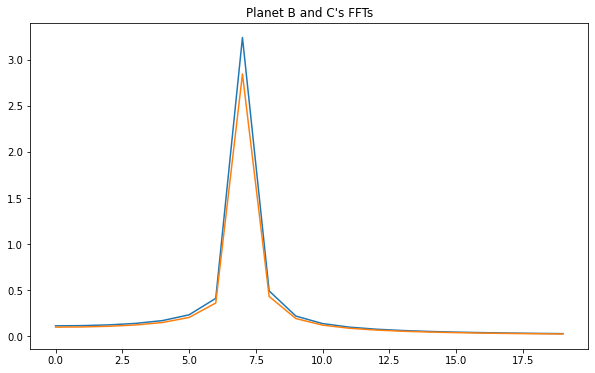

In [53]:
plt.figure(figsize=(10,6))

b_fft = 2 / num_steps * np.abs(fft.fft(b_complex_incs_deg.real))
c_fft = 2 / num_steps * np.abs(fft.fft(c_complex_incs_deg.real))
max_freq = np.argmax(b_fft)

mode_amp = np.array([b_fft[max_freq], c_fft[max_freq]])
mode_amp = mode_amp / np.linalg.norm(mode_amp)
print(f'Mode amp: {mode_amp}')
plt.plot(b_fft[ :20])
plt.plot(c_fft[ :20])

plt.title("Planet B and C's FFTs")
plt.show()

## Sanity check

Do a sanity check with `scipy.optimize`. See [this link](https://scipy-lectures.org/intro/scipy/auto_examples/plot_curve_fit.html).

Planet B params: [ 3.32072271e+00  1.12080118e-02 -1.58200738e+00 -9.52299677e-06]


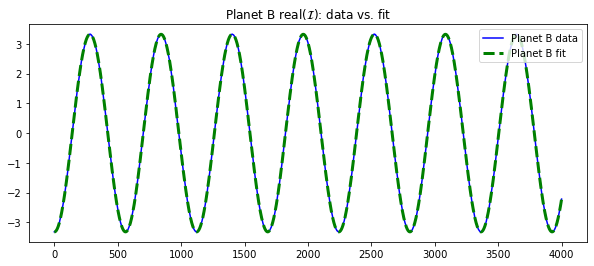

Planet C params: [ 2.91485406e+00  1.12080118e-02  1.55958523e+00 -1.14403555e-05]


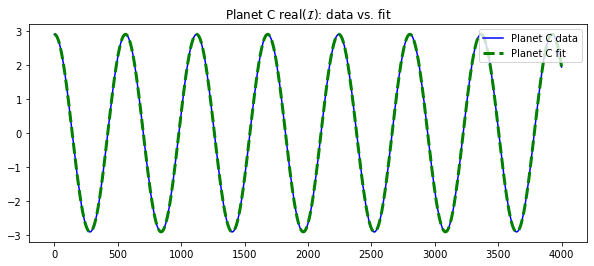

In [60]:
def test_func(x, a, b, c, d):
    '''
    Returns a sin function a*sin(bx + c) + d.
    
    '''
    
    return a * np.sin(b * x + c) + d

# Given our FFT results as an initial guess, use curve_fit to infer the parameters
# of Planet B's complex inclination series (real component).
guess_b = [b_fft[max_freq], (2*np.pi/N) * max_freq, 0, 0]
params, params_covariance = optimize.curve_fit(test_func, times, b_series,
                                               p0=guess_b)
print(f'Planet B params: {params}')
a, b, c, d = params

plt.figure(figsize=(10,4))
plt.plot(times, b_series, color='b', label='Planet B data')
plt.plot(times, test_func(times, a, b, c, d), 'g--', lw='3', label='Planet B fit')

plt.title('Planet B real($\mathcal{I}$): data vs. fit')
plt.legend(loc='upper right')
plt.show()

# Same as above with Planet C.
guess_c = [c_fft[max_freq], (2*np.pi/N) * max_freq, 0, 0]
params, params_covariance = optimize.curve_fit(test_func, times, c_series,
                                               p0=guess_c)
print(f'Planet C params: {params}')
a, b, c, d = params

plt.figure(figsize=(10,4))
plt.plot(times, c_series, color='b', label='Planet C data')
plt.plot(times, test_func(times, a, b, c, d), 'g--', lw='3', label='Planet C fit')

plt.title('Planet C real($\mathcal{I}$): data vs. fit')
plt.legend(loc='upper right')
plt.show()

# Method 2: Analytic formula

I check that the mode frequency formula (Su & Lai 2022, Equation A2) matches our simulation's frequencies.

In [61]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or const.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [62]:
planet_inds = ['b', 'c']

# calculate omega_jk values in yr^-1 (but without the unit)
# format: omega_jk = mode_freq(j_params['a']*u.au, k_params['a']*u.au, \
    # k_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value
for j in planet_inds:
    for k in planet_inds:
        if (j == k): continue
        exec('omega_' + j + k + ' = ' + \
             'mode_freq(' + j + "_params['a']*u.au, " + k + "_params['a']*u.au, " + \
             k + "_params['m']*const.M_sun, star_mass*const.M_sun).to(u.yr**-1).value")

## NOTE: This implementation is for 2 planets.
mat = np.array([
    [-omega_bc, omega_bc],
    [omega_cb, -omega_cb]
])
 
eigs, eigvs = np.linalg.eig(mat)
prec_freq = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigv = eigvs[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigv = np.squeeze(prec_eigv).T # reshape to (2,), ie each row is an eigv
zero_mode_ind = np.where(np.abs(eigs) < 1e-10)[0] # index of mode w/ frequency=0

# Note: for 2 planets, prec_freq = -(w_js + w_sj)
print(f'Period: %.2f years' % (2 * np.pi / (-prec_freq)))
print(f'Non-zero mode frequencies: {prec_freq}')
print(f'Corresponding mode eigenvectors: {prec_eigv}')

Period: 484.67 years
Non-zero mode frequencies: [-0.01296382]
Corresponding mode eigenvectors: [-0.75148311  0.65975233]


In [ ]:
np.linalg.eig?

In [ ]:
print(eigs)
print(eigvs)

In [ ]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector: {np.matmul(mat, np.squeeze(prec_eigv)) / prec_eigv}")
print(f'Eigenvalues: {eigs}')

## Mode amplitudes (attempt 1; doesn't work)

**these equations are outdated; see yubo_two_planet.ipynb**

Calculate mode amplitudes given the initial complex inclination vector $\vec{\mathcal{I}}_0$ (which has $n$ entries) and the eigenvectors. 

Let $n$ be the number of planets. Reading from Eq. A1 in Su & Lai (2022), the eigenvalue problem can be written as:

$$ \frac{d\vec{\mathcal{I}}}{dt} = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \frac{\vec{v}_k}{|\vec{v}_k|}\right)\vec{v}_k = i\sum_{k=1}^{n-1} g_k \left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k \equiv \sum_{k=1}^{n-1} g_k \vec{A}_k.$$

The second-to-last step comes from the fact that the eigenvectors are normalized, so $|\vec{v}_k| = 1$. The goal is to find the $n-1$ mode amplitudes, each of which is defined as $\vec{A}_k \equiv i\left(\vec{\mathcal{I}}_0 \cdot \vec{v}_k\right)\vec{v}_k$.

To get the complex inclination variation for a given planet $n$, we take the $n$th component of the above equation:

$$ \frac{d\mathcal{I}_n}{dt} = \sum_{k=1}^{n-1} g_k \left(\mathcal{I}_{0, n} v_{k, n}\right)v_{k,n} \equiv \sum_{k=1}^{n-1} g_k A_{k,n}.$$



In [65]:
def get_mode_amps(complex_inc_0, eigvs, zero_mode_ind):
    '''
    Given the initial complex inclination vector inc_0 and the set of 
    eigenvectors (eigvs) for a system, compute the mode amplitudes 
    (which are the projections of inc_0 onto the eigenvectors). NOTE: In the below
    calculation, the eigenvector with eigenvalue 0 is set to the zero vector.
    (The index of this eigenvector is given by zero_mode_ind.)
    
    Let n be the number of planets. inc_0 has shape (n,), and eigvs has shape
    (n, n), where the columns (i.e. eigvs[:,i]) are the eigenvectors. The output 
    will have shape (n, n), and the ith column corresponds to mode amplitude i.
    (The column at A_vecs[:,zero_mod_ind] will be the zero vector.)
    
    
    '''
    
    n = len(complex_inc_0)
    complex_inc_0 = np.expand_dims(complex_inc_0, axis=1) # change shape to (n, 1)
    eigvs[:,zero_mode_ind] = np.zeros((n, 1))
    
    scalars = np.matmul(np.conj(complex_inc_0.T), eigvs) # complex inner product 
    diag_mat = np.zeros((n,n), dtype=complex)
    np.fill_diagonal(diag_mat, scalars)
    A_vecs = 1j * np.matmul(eigvs, diag_mat)
    
    print(f'complex_inc_0.T: {complex_inc_0}')
    print(f'scalars: {scalars}')
    print(f'diag_mat: {diag_mat}')
    
    return A_vecs

In [66]:
temp_i = 100
inc_0_temp = np.asarray([b_complex_incs_deg[temp_i], c_complex_incs_deg[temp_i]])
mode_amps = get_mode_amps(inc_0_temp, eigvs, zero_mode_ind)
print('Mode amplitudes:')
print(mode_amps)
print('Magnitudes of mode amplitudes:')
print(np.abs(mode_amps))

complex_inc_0.T: [[-1.47735639+2.97618995j]
 [ 1.29672181-2.61233465j]]
scalars: [[1.96572361+3.96005035j 0.        +0.j        ]]
diag_mat: [[1.96572361+3.96005035j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j        ]]
Mode amplitudes:
[[ 2.97591095-1.47720809j  0.        +0.j        ]
 [-2.61265245+1.29689074j  0.        +0.j        ]]
Magnitudes of mode amplitudes:
[[3.32237712 0.        ]
 [2.91682677 0.        ]]
